In [1]:
import os
import pandas
import pathlib
import numpy
import collections
import abc
import numpy.typing

In [2]:
%%html
<!-- Disable line wrapping in cell outputs to make the output more readable -->
<style>
div.jp-OutputArea-output pre {
    white-space: pre;
}
</style>

# Load data

In [3]:
os.chdir("..")

In [4]:
import pandas
import functools
from typing import Mapping, Callable
from util import flatten1
from prov_collectors import PROV_COLLECTORS
from workloads import WORKLOADS
import operator

rel_qois = ["cputime", "walltime", "memory"]
abs_qois = ["storage", "n_ops", "n_unique_files"]
output = pathlib.Path("output")
output.mkdir(exist_ok=True)

**Note**: I suggest calling `result/bin/python runner.py ...` to execute the runs _before_ running this notebook. Then call `get_results(...)` with exactly the same arguments. `get_results(...)` can kick of new runs, but it can also draw results from the cache if those runs have already been done.

In [5]:
from experiment import get_results
from workloads import WORKLOAD_GROUPS
from prov_collectors import PROV_COLLECTOR_GROUPS
from util import flatten1

collectors = list(flatten1([
    PROV_COLLECTOR_GROUPS[collector_name]
    for collector_name in ["working"]
]))
workloads = list(flatten1([
    WORKLOAD_GROUPS[workload_name]
    for workload_name in ["working-low-mem"]
]))
iterations = 3
ignore_failures = False
rerun = False
df = get_results(
    collectors,
    workloads,
    iterations=iterations,
    seed=0,
    ignore_failures=ignore_failures,
    rerun=rerun,
    parallelism=1,
)

In [161]:
df = (
    df
    # Get rid of unused columns
    # They just soak up memory
    .drop(columns=[col for col in ["collector_method", "collector_submethod"] if col in df.columns])

    # Get rid of "failure" runs which have walltime == 0.0
    [lambda df: df["walltime"] != 0.0]

    # Sciunits runs out of memory on some benchmarks (without failing)
    [lambda df: df["collector"] != "sciunit"]

    # These are impossibly fast in fsatrace
    [lambda df: df["workload"] != "lm-open/close"]

    # We can refer to the 1st or 2nd run of X workload in Y collector
    .assign(iter=lambda df: df.groupby(["collector", "workload"], observed=True).cumcount())

    .assign(n_unique_files=lambda df: numpy.zeros(len(df)))
)

In earlier versions of the code, I had each BLAST query as its own benchmark. This resulted in imbalanced clusters, hundreds of BLAST queries, and about 70 of everything else. This biased the metrics later on to give undue weight to BLAST-style programs. This code balanced the clusters by aggregating some of the BLAST benchmarks into one benchmark, bmark_agg = {bmark1; bmark2; bmark3;}. However, I started doing that earlier on in the chain, so we don't need this anymore.

In [162]:
if False:
    blast_df = (
        df
        [df["workload_kind"] == "blast"]
        .assign(blast_kind=lambda df: df["workload"].str[:6])
        .groupby(["collector", "blast_kind", "iter"], observed=True)
        .agg({
            "cputime": "sum",
            "walltime": "sum",
            "memory": "max",
            "storage": "sum",
            "n_ops": "sum",
            "n_unique_files": "sum",
            "workload_kind": "first",
            "op_type_counts": lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter()),
        })
        .reset_index()
        .rename(columns={"blast_kind": "workload"})
        [df.columns]
    )
else:
    blast_df = None
blast_df

In [163]:
if False:
    df_with_balanced_clusters = (
        pandas.concat([
            df[df["workload_kind"] != "blast"],
            blast_df,
        ])
        .assign(workload=lambda df: df["workload"].astype("category"))
    )
else:
    df_with_balanced_clusters = df
df_with_balanced_clusters["workload_kind"].value_counts()

workload_kind
lmbench        324
splash-3       180
blast          108
archive         90
simple          90
http_server     90
unarchive       90
shell           54
ftp_client      54
notebook        54
pdflatex        36
copy            36
gcc             36
http_client     36
spack           36
python          36
vcs             36
postmark        18
Name: count, dtype: int64

Yes, there are more lmbench than others, but not by too many.

Rename the benchmarks to match their names in the paper.

In [164]:
df_with_balanced_clusters = (
    df_with_balanced_clusters
    .assign(
        workload_triple=lambda df: [
            {
                "notebook": lambda: (
                    "Data science", "Notebook", {"a-data-sci": "nb-1", "comprehens": "nb-2", "titanic-da": "nb-3"}[name],
                ),
                "archive": lambda: ("Tar", "Archive", name.split(' ')[-1].replace(" archive", "raw")),
                "unarchive": lambda: ("Tar", "Unarchive", name.split(' ')[-1].replace(" unarchive", "raw")),
                "http_server": lambda: ("HTTP", "srv/traffic", name.replace('python http.server', 'simplehttp')),
                "http_client": lambda: ("HTTP", "srv/client", name),
                "ftp_server": lambda: ("FTP", "srv/traffic", name),
                "ftp_client": lambda: ("FTP", "srv/client", name.split('-')[-1]),
                "blast": lambda: ("BLAST", "", "mega" if name == "megablast" else name),
                "shell": lambda: ("Utils", "bash", name),
                "lmbench": lambda: ("IO bench", "lmbench", name.replace('lm-', '')),
                "copy": lambda: ("cp", "", name.split(' ')[-1]),
                "simple": lambda: ("Utils", "", name),
                "vcs": lambda: ("VCS checkout", "", name.replace('schema-validation', 'hg-repo-1').replace('setuptools_scm', 'git-repo-1')),
                "postmark": lambda: ("IO bench", "postmark", "main"),
                "pdflatex": lambda: ("Compile", "w/latex", name.replace('latex-', '').replace('test2', 'doc2').replace('test', 'doc1')),
                "splash-3": lambda: ("CPU bench", "SPLASH-3", name.split(' ')[-1].split('-')[-1]),
                "spack": lambda: ("Compile", "w/Spack", name.split(' ')[-1].split("~")[0]),
                "gcc": lambda: ("Compile", "w/gcc", name.split(' ')[-1].replace('gcc-', '')),
                "python": lambda: ("Data science", "python", name),
            }[kind]()
            for kind, name in df[["workload_kind", "workload"]].values
        ],
        collector=lambda df: [
            {
                "care": "CARE",
                "fsatrace": "fsatrace",
                "noprov": "(none)",
                "reprozip": "ReproZip",
                "rr": "RR",
                "strace": "strace",
                "sciunit": "Sciunit",
            }[collector]
            for collector in df["collector"]
        ],
    )
    .assign(
        workload_kind=lambda df: [f"{a} {b}" for a, b, c in df.workload_triple],
        workload_shortname=lambda df: [c for a, b, c in df.workload_triple],
        workload=lambda df: [f"{a} {b} ({c})" for a, b, c in df.workload_triple],
    )
    .assign(
        workload_kind=lambda df: df["workload_kind"].astype("category"),
        workload_shortname=lambda df: df["workload_shortname"].astype("category"),
        workload=lambda df: df["workload"].astype("category"),
        collector=lambda df: df["collector"].astype("category"),
    )
)

In [165]:
collector_order = [
    "(none)",
    "fsatrace",
    "CARE",
    "strace",
    "RR",
    "ReproZip",
]
assert df["collector"].nunique() == len(collector_order)

In [166]:
agged = (
    df_with_balanced_clusters
    .groupby(["collector", "workload"], observed=True, as_index=True)
    .agg(**{
        **{
            f"{qoi}_std": pandas.NamedAgg(qoi, "std")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_mean": pandas.NamedAgg(qoi, "mean")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_low": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 5))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_high": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 95))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_sorted": pandas.NamedAgg(qoi, lambda data: list(sorted(data)))
            for qoi in abs_qois + rel_qois
        },
        "op_type_counts_sum": pandas.NamedAgg(
            "op_type_counts",
            lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter()),
        ),
        "count": pandas.NamedAgg("walltime", lambda walltimes: len(walltimes)),
        "workload_kind": pandas.NamedAgg("workload_kind", lambda workload_kinds: workload_kinds.iloc[0]),
        "workload_shortname": pandas.NamedAgg("workload_shortname", lambda workload_shortnames: workload_shortnames.iloc[0]),
    })
    .assign(**{
        **{
            f"{qoi}_rel": lambda df, qoi=qoi: df[f"{qoi}_std"] / df[f"{qoi}_mean"]
            for qoi in abs_qois + rel_qois
        },
        "rel_slowdown": lambda df: df["walltime_mean"] / df.loc["(none)"]["walltime_mean"],
        "abs_slowdown": lambda df: df["walltime_mean"] - df.loc["(none)"]["walltime_mean"],
        # workload_kind gets set to a String/PyObj in the previous aggregation. This convert it back to categorical
        "workload_kind": lambda df: df["workload_kind"].astype(df_with_balanced_clusters["workload_kind"].dtype),
        "workload_shortname": lambda df: df["workload_shortname"].astype(df_with_balanced_clusters["workload_shortname"].dtype),
    })
    .assign(**{
        "log_rel_slowdown": lambda df: numpy.log(df["rel_slowdown"]),
    })
    .loc[collector_order]
)

# Look for anomolies before proceeding

In [167]:
import matplotlib.pyplot

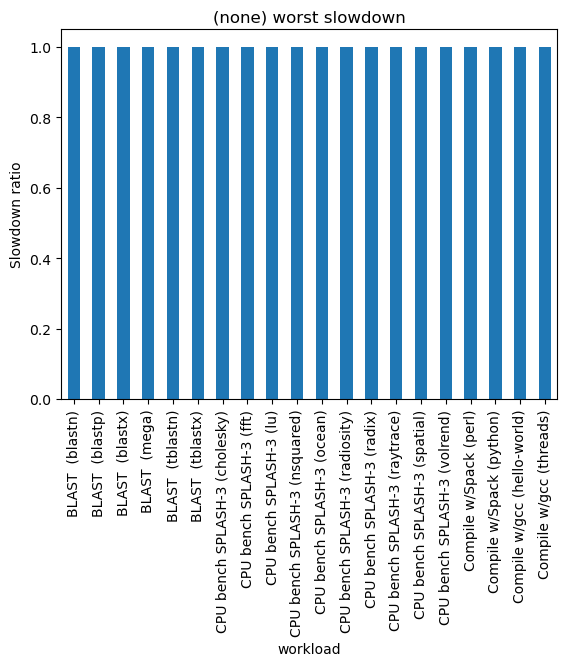

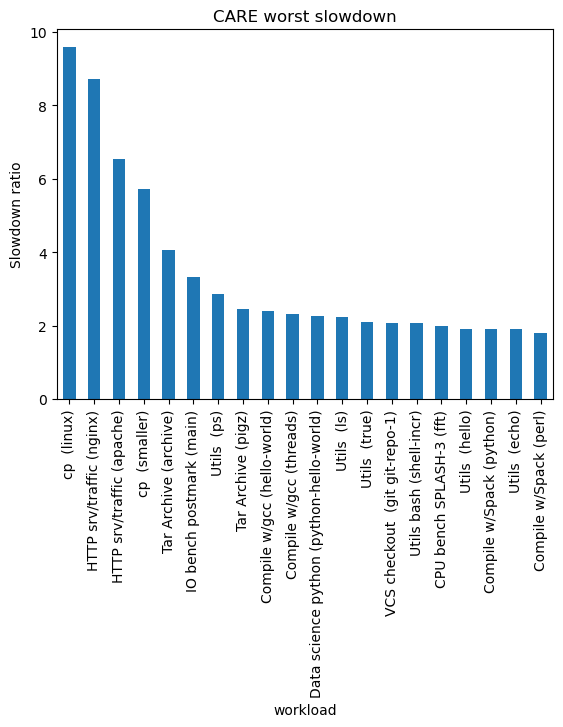

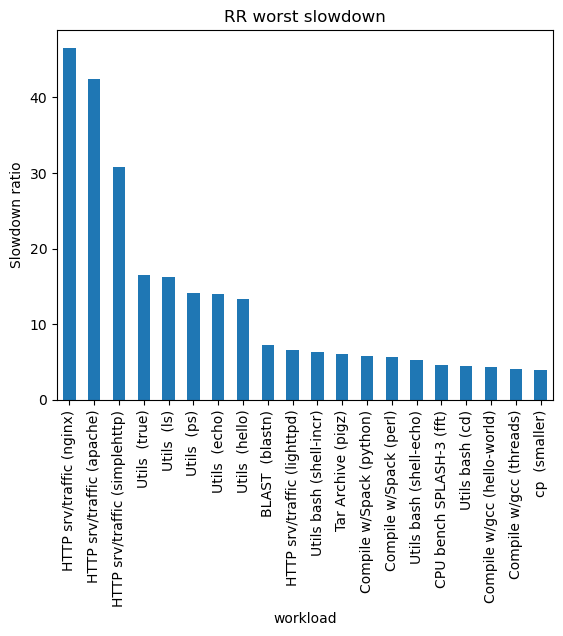

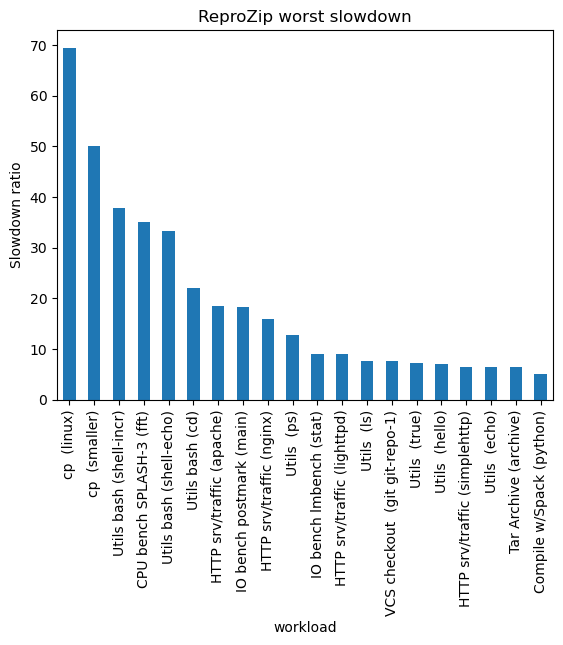

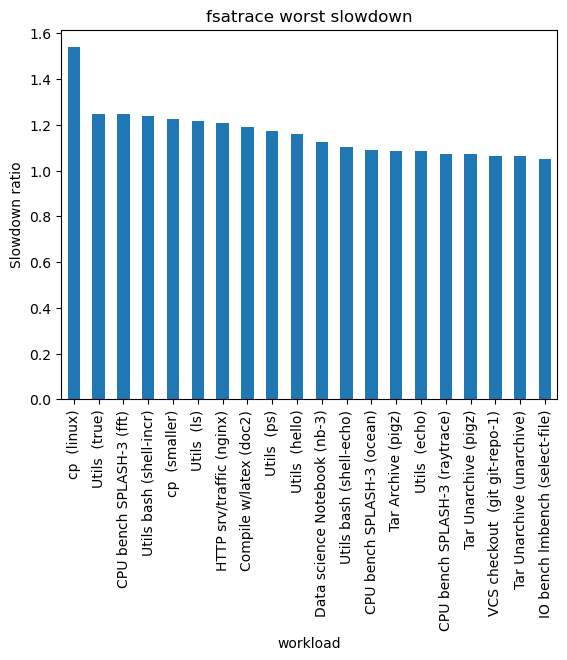

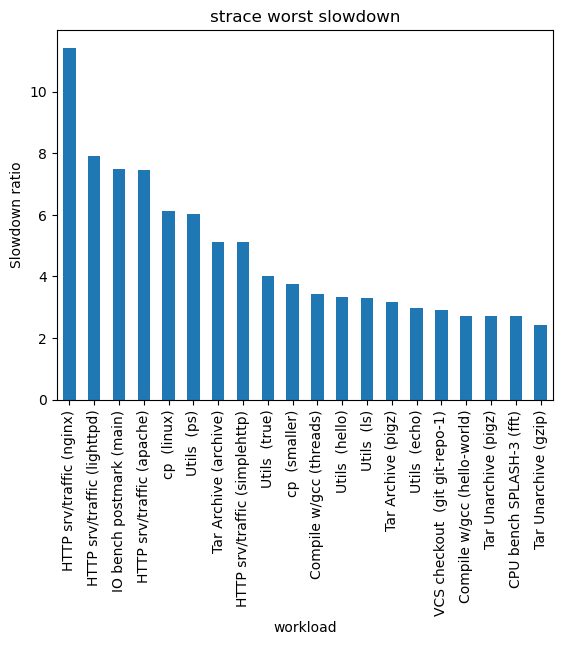

In [168]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = agged.loc[collector]["rel_slowdown"].nlargest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} worst slowdown")
    ax.set_ylabel("Slowdown ratio")
    display(fig)

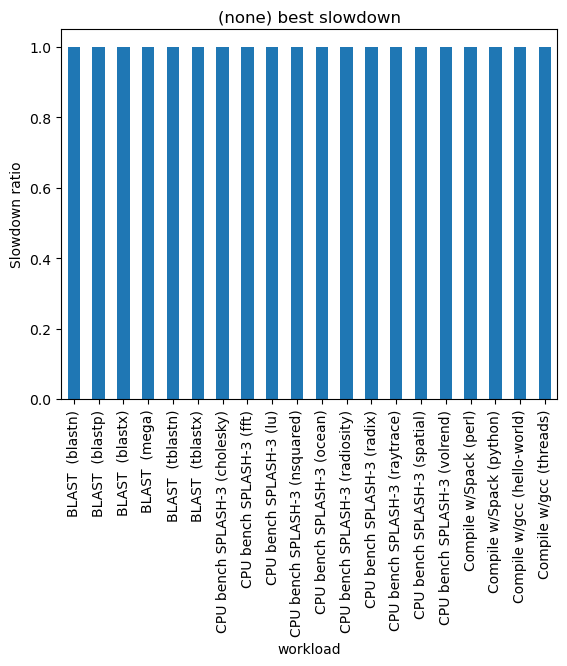

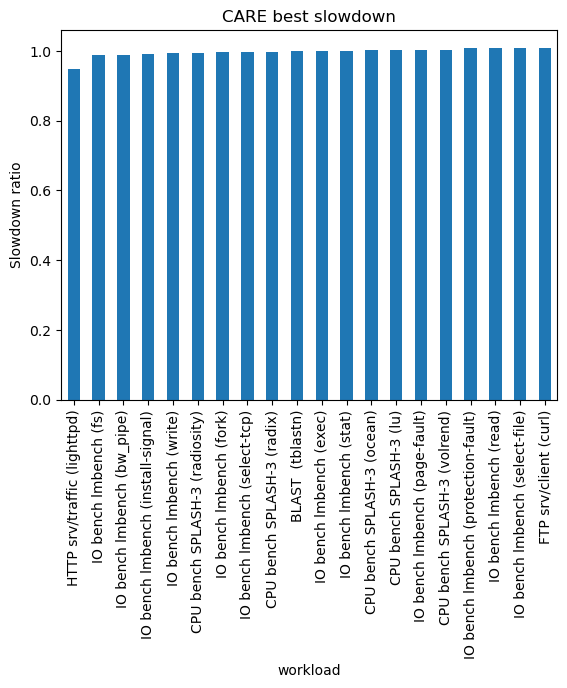

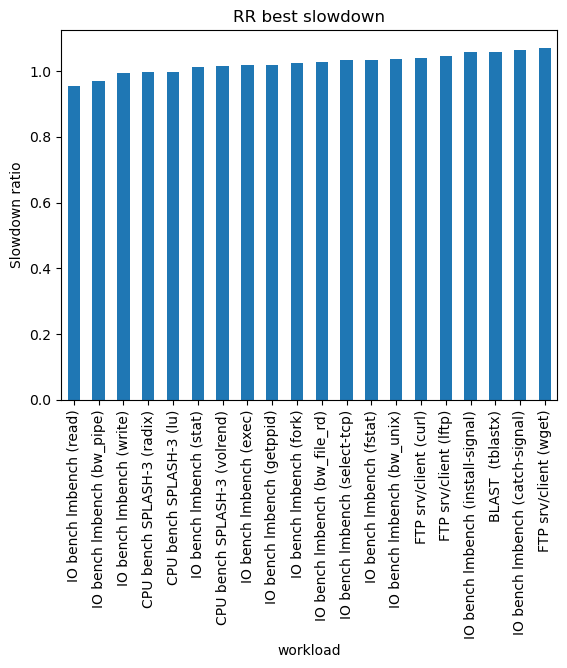

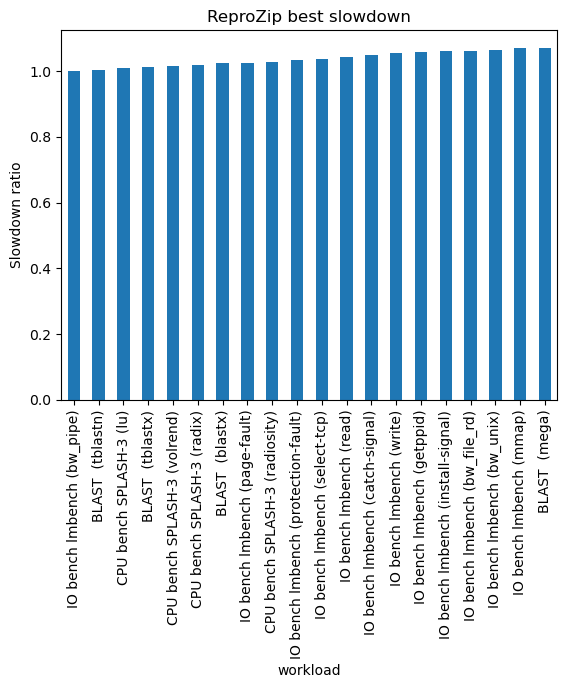

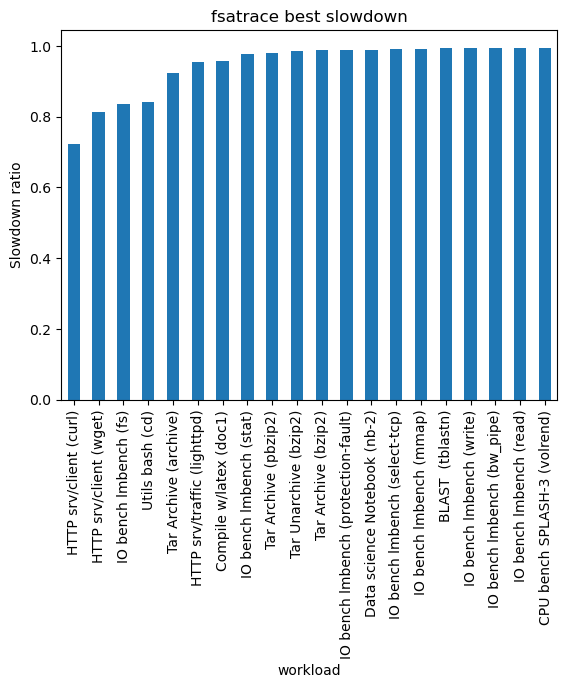

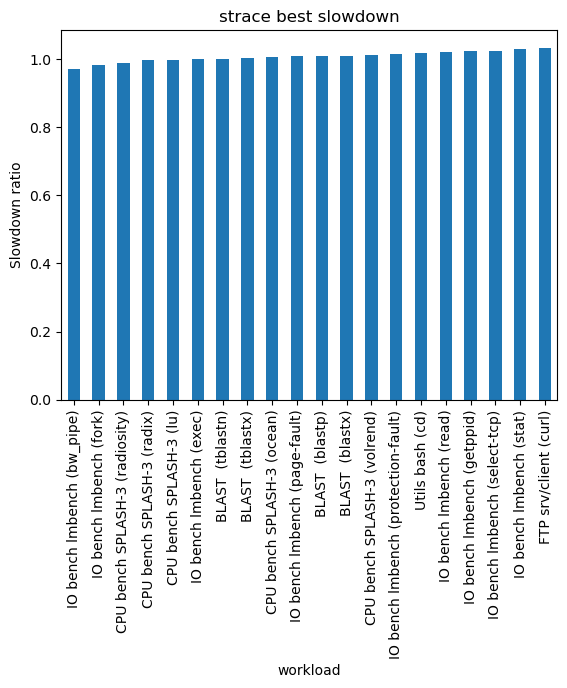

In [169]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = agged.loc[collector]["rel_slowdown"].nsmallest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} best slowdown")
    ax.set_ylabel("Slowdown ratio")
    display(fig)

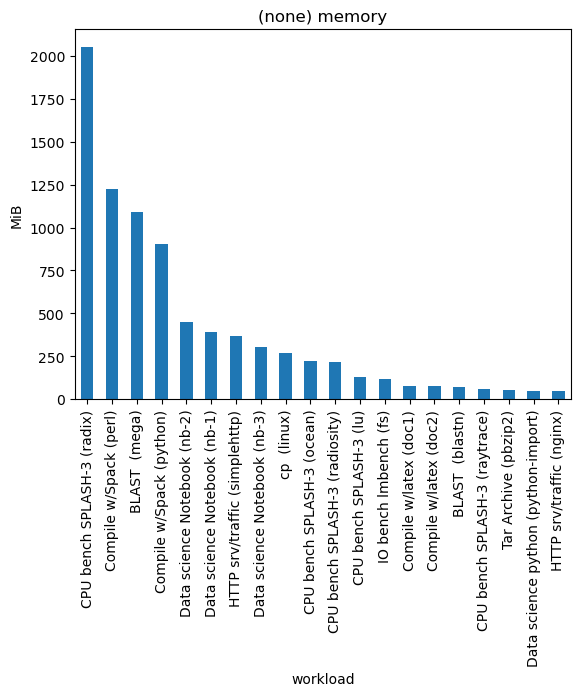

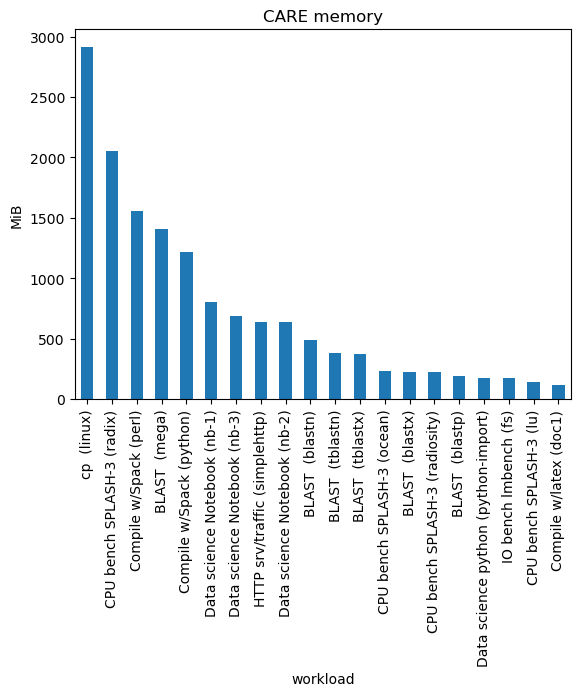

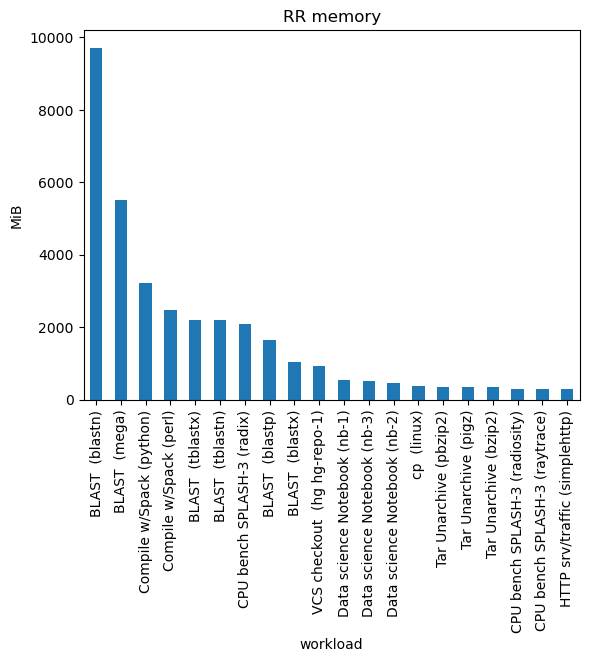

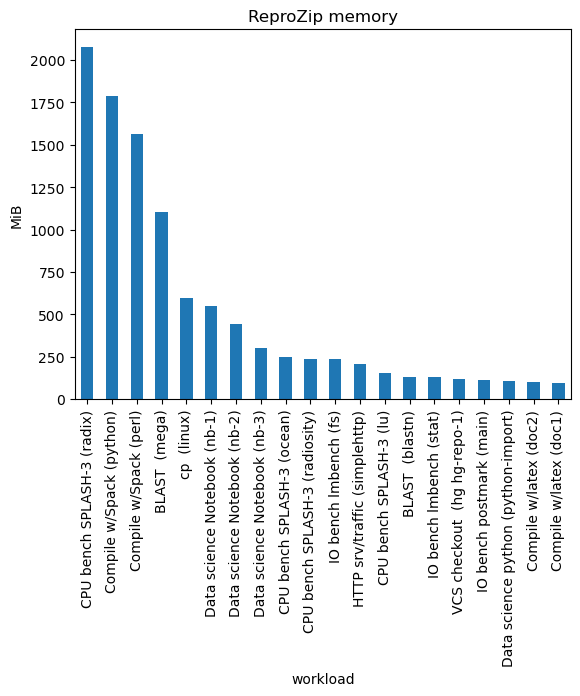

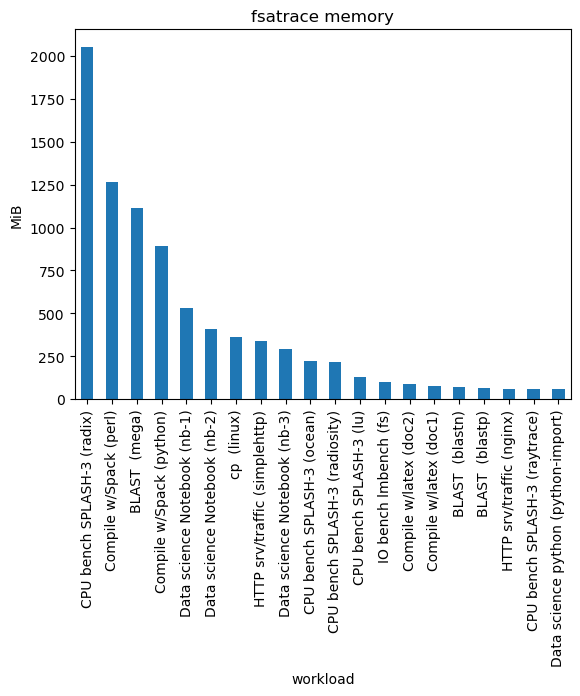

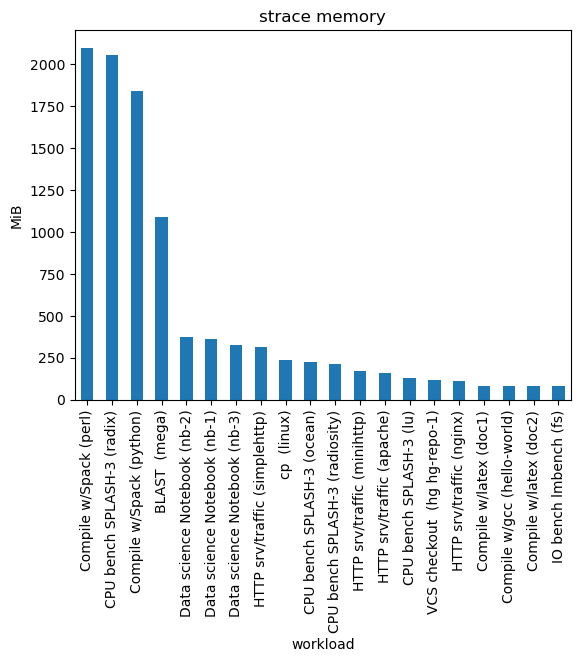

In [170]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = (agged.loc[collector]["memory_mean"] / 2**20).nlargest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} memory")
    ax.set_ylabel("MiB")
    display(fig)

# Make some tables

In [171]:
import pathlib
output_dir = pathlib.Path("../docs/benchmark_suite/generated")

In [172]:
(
    agged
    .reset_index()
    .groupby("workload_kind", observed=True)
    .agg(**{
        #"subkinds": pandas.NamedAgg("workload_kind", lambda df: set(df)),
        "Instances": pandas.NamedAgg("workload", lambda series: len(set(series))),
        "Mean walltime (s)": pandas.NamedAgg("walltime_mean", lambda series: "{:.0f}".format(numpy.mean(series))),

        # Note that geomean x = exp (arithmean (log (x)))
        # This is quite difficult to interpret because rr is such an outlier, it brings the avg up
        #"gmean overhead (%)": pandas.NamedAgg("log_rel_slowdown", lambda series: "{:.0f}".format(100 * (numpy.exp(numpy.mean(series)) - 1))),
    })
)

,Instances,Mean walltime (s)
workload_kind,,
BLAST,6,137
CPU bench SPLASH-3,10,19
Compile w/Spack,2,297
Compile w/gcc,2,11
Compile w/latex,2,1
Data science Notebook,3,19
Data science python,2,5
FTP srv/client,3,5
HTTP srv/client,2,0


In [173]:
log_to_human_readable = lambda series: r"{:.0f}".format(
    100 * (numpy.exp(numpy.mean(series)) - 1),
    # 100 * (
    #     (numpy.exp(numpy.mean(series) + numpy.std(series)) - numpy.exp(numpy.mean(series) - numpy.std(series)))
    #     / 2
    # ),
)

In [174]:
print(
    agged
    .reset_index()
    .groupby(["collector", "workload_kind"], observed=True)
    .agg({"log_rel_slowdown": "mean"})
    .assign(**{
        "gmean": lambda df: [
            log_to_human_readable(x)
            for x in df.log_rel_slowdown
        ],
    })
    .reset_index()
    .pivot(index="collector", columns="workload_kind", values="gmean")
    .pipe(lambda df: (df.index.__setattr__("name", None), df)[1])
    .pipe(lambda df: (df.columns.__setattr__("name", None), df)[1])
    .loc[collector_order]
    .transpose()
    .to_latex()
    .replace("\\bottomrule", "\n".join([
        r"\midrule",
        "Total (gmean) & " + " & ".join(list(
            agged
            .groupby(level=0, observed=True)
            .agg(**{
                "gmean": pandas.NamedAgg("log_rel_slowdown", log_to_human_readable),
            })
            .transpose()
            [collector_order]
            .loc["gmean"]
        )) + r" \\",
        r"\bottomrule",
    ]))
)

\begin{tabular}{lllllll}
\toprule
 & (none) & fsatrace & CARE & strace & RR & ReproZip \\
\midrule
BLAST  & 0 & 0 & 2 & 2 & 93 & 8 \\
CPU bench SPLASH-3 & 0 & 5 & 9 & 16 & 49 & 75 \\
Compile w/Spack & 0 & 0 & 85 & 95 & 470 & 336 \\
Compile w/gcc & 0 & 4 & 136 & 206 & 321 & 344 \\
Compile w/latex & 0 & 7 & 72 & 40 & 23 & 288 \\
Data science Notebook & 0 & 4 & 15 & 32 & 20 & 174 \\
Data science python & 0 & 5 & 85 & 84 & 150 & 346 \\
FTP srv/client & 0 & 1 & 2 & 4 & 5 & 18 \\
HTTP srv/client & 0 & -23 & 20 & 33 & 165 & 248 \\
HTTP srv/traffic & 0 & 5 & 135 & 414 & 1261 & 724 \\
IO bench lmbench & 0 & -1 & 1 & 3 & 11 & 25 \\
IO bench postmark & 0 & 2 & 231 & 650 & 259 & 1733 \\
Tar Archive & 0 & -0 & 75 & 113 & 179 & 140 \\
Tar Unarchive & 0 & 4 & 44 & 114 & 195 & 149 \\
Utils  & 0 & 17 & 118 & 280 & 1378 & 697 \\
Utils bash & 0 & 5 & 75 & 20 & 426 & 2933 \\
VCS checkout  & 0 & 5 & 71 & 160 & 177 & 428 \\
cp  & 0 & 37 & 641 & 380 & 232 & 5791 \\
\midrule
Total (gmean) & 0 & 3 & 43 & 65 & 

In [175]:
import scipy.spatial.distance

In [176]:
c = [agged.loc[collector, "log_rel_slowdown"] for collector in agged.index.levels[0]]
for i in range(len(c)):
    for j in range(i):
        print(
            agged.index.levels[0][i],
            agged.index.levels[0][j],
            numpy.log(scipy.spatial.distance.cosine(c[i].to_numpy(), c[j].to_numpy())),
        )

CARE (none) -inf
RR (none) -inf
RR CARE -1.5745962611317594
ReproZip (none) -inf
ReproZip CARE -2.0083817746365202
ReproZip RR -1.749478216368445
fsatrace (none) -inf
fsatrace CARE -0.9363038244820421
fsatrace RR -0.5854559874628154
fsatrace ReproZip -0.7584536705866554
strace (none) -inf
strace CARE -2.1493871956490818
strace RR -2.1477148469917773
strace ReproZip -1.8118617422734302
strace fsatrace -0.7325431874354165


/nix/store/9kgcvj0qdcf01mq20d6ickh63az0bjn2-python3-3.10.13-env/lib/python3.10/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/tmp/ipykernel_8855/397160844.py:7: RuntimeWarning: divide by zero encountered in log
  numpy.log(scipy.spatial.distance.cosine(c[i].to_numpy(), c[j].to_numpy())),


In [177]:
import seaborn

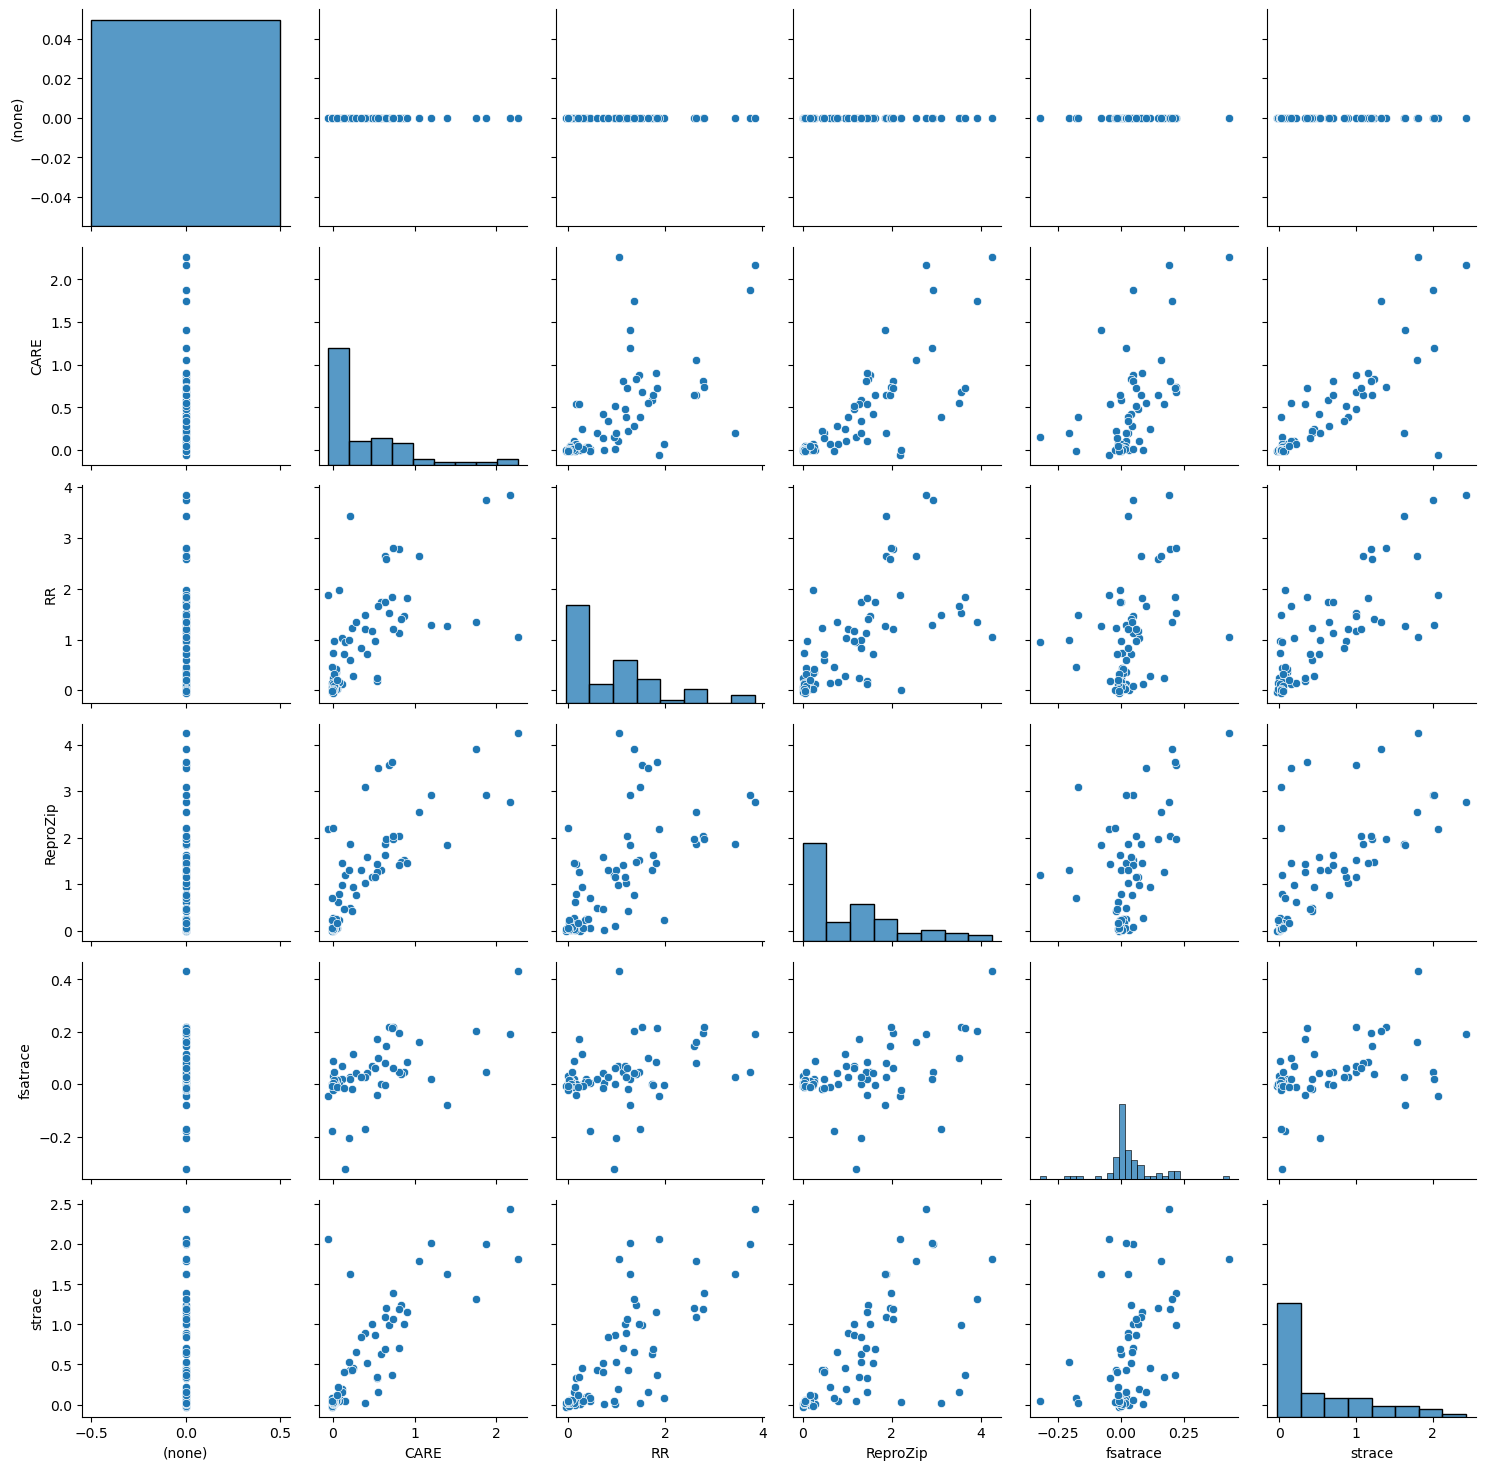

In [178]:
g = seaborn.PairGrid(
    agged.reset_index().pivot(columns="collector", index="workload", values="log_rel_slowdown")
)
g.map_diag(seaborn.histplot)
g.map_offdiag(seaborn.scatterplot)

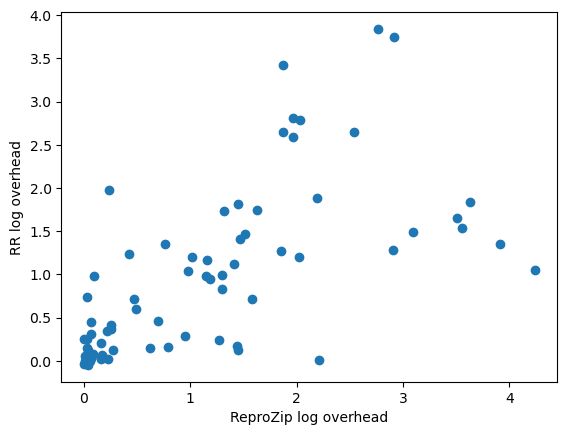

In [179]:
fig = matplotlib.figure.Figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    agged.loc["ReproZip", "log_rel_slowdown"],
    agged.loc["RR", "log_rel_slowdown"],
    linestyle="",
    marker="o",
)
ax.set_xlabel("ReproZip log overhead")
ax.set_ylabel("RR log overhead")
display(fig)

/tmp/ipykernel_8855/31621408.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(["(none)"])


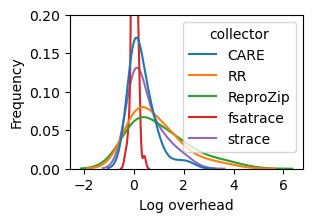

In [216]:
fig = matplotlib.figure.Figure(figsize=(3, 2))
ax = fig.add_subplot(1, 1, 1)
seaborn.kdeplot(
    (
        agged
        .drop(["(none)"])
        .reset_index()
        .assign(collector=lambda df: df["collector"].astype(str).astype("category"))
        .pivot(columns="collector", index="workload", values="log_rel_slowdown")
    ),
    ax=ax,
    bw_adjust=1.5
)
#ax.set_yscale('log')
ax.set_ylim(0, 0.2)
ax.set_xlabel("Log overhead")
ax.set_ylabel("Frequency")
ax.figure.savefig(output_dir / "log_overhead_hist.svg", bbox_inches="tight")
display(fig)

## Feature engineering

In [188]:
import collections
all_syscalls = collections.Counter()
for counter in df[df["collector"] == "strace"]["op_type_counts"]:
    all_syscalls += counter
all_syscalls

Counter({'newfstatat': 27360987,
         'openat': 27027905,
         'readlink': 22529503,
         'close': 10749821,
         'unlink': 1054866,
         'access': 941593,
         'connect': 932631,
         'utimensat': 835990,
         'creat': 832632,
         'exit_group': 526690,
         'clone': 448584,
         'execve': 380195,
         'clone3': 279300,
         'dup2': 261824,
         'shutdown': 231103,
         'accept4': 208467,
         'exit': 206826,
         'bind': 150717,
         'pipe2': 150500,
         'unlinkat': 130080,
         'mkdirat': 65339,
         'mkdir': 63412,
         'symlink': 59736,
         'chmod': 49980,
         'rename': 42823,
         'vfork': 37998,
         'chdir': 31041,
         'rmdir': 12955,
         'fchmodat': 12013,
         'fsetxattr': 7662,
         'dup': 2153,
         'listxattr': 435,
         'renameat': 423,
         'symlinkat': 420,
         'accept': 383,
         'fchmod': 123,
         'link': 111,
         

In [189]:
syscall_groups = {
    "socket": {"accept4", "connect", "bind", "accept", "shutdown"},
    "metadata": {"newfstatat", "access", "fstat", "chmod", "fchmod", "utimensat"},
    "dir": {"mkdir", "rmdir", "mkdirat", "rename", "unlink", "link", "readlink", "symlink", "symlinkat"},
    "file": {"creat", "open", "openat", "close", "ftruncate"},
    "exec": {"execve"},
    "fork": {"clone", "clone3", "fork", "vfork"},
    "exits": {"exit", "exit_group"},
    "IPC": {"dup", "dup2", "dup3", "pipe2", "mkfifo"},
    "chdir": {"chdir"},
}
syscall_groups["other"] = {
    syscall
    for syscall in all_syscalls
    if not any(syscall in group for group in syscall_groups.values())
}
syscall_groups

{'socket': {'accept', 'accept4', 'bind', 'connect', 'shutdown'},
 'metadata': {'access', 'chmod', 'fchmod', 'fstat', 'newfstatat', 'utimensat'},
 'dir': {'link',
  'mkdir',
  'mkdirat',
  'readlink',
  'rename',
  'rmdir',
  'symlink',
  'symlinkat',
  'unlink'},
 'file': {'close', 'creat', 'ftruncate', 'open', 'openat'},
 'exec': {'execve'},
 'fork': {'clone', 'clone3', 'fork', 'vfork'},
 'exits': {'exit', 'exit_group'},
 'IPC': {'dup', 'dup2', 'dup3', 'mkfifo', 'pipe2'},
 'chdir': {'chdir'},
 'other': {'fchdir',
  'fchmodat',
  'fsetxattr',
  'lchown',
  'linkat',
  'listxattr',
  'mknodat',
  'renameat',
  'unlinkat'}}

In [190]:
noprov = agged.loc["(none)"]
strace = agged.loc["strace"]
features_df = pandas.DataFrame({
    "cputime_per_sec": noprov["cputime_mean"] / noprov["walltime_mean"],
    #"memory_mean_per_sec": noprov["memory_mean"] / noprov["walltime_mean"],
    **{
        group_name + "_syscalls_per_sec": strace["op_type_counts_sum"].map(lambda op_type_counts: sum(
            op_type_counts[syscall_name]
            for syscall_name in syscall_names
        )) / (noprov["walltime_mean"] * noprov["count"])
        for group_name, syscall_names in syscall_groups.items()
    },
    #"n_ops_per_sec": strace["n_ops_mean"] / noprov["walltime_mean"],
})
abs_features_df = pandas.DataFrame({
    **{
        group_name + "_syscalls": strace["op_type_counts_sum"].map(lambda op_type_counts: sum(
            op_type_counts[syscall_name]
            for syscall_name in syscall_names
        )) / (noprov["count"])
        for group_name, syscall_names in syscall_groups.items()
    },
    "noprov_time": noprov["walltime_mean"],
    "constant": 1,
})
features_df

,cputime_per_sec,socket_syscalls_per_sec,metadata_syscalls_per_sec,dir_syscalls_per_sec,file_syscalls_per_sec,exec_syscalls_per_sec,fork_syscalls_per_sec,exits_syscalls_per_sec,IPC_syscalls_per_sec,chdir_syscalls_per_sec,other_syscalls_per_sec
workload,,,,,,,,,,,
BLAST (blastn),0.999837,34.222154,958.186094,263.510587,959.178536,10.300868,13.688862,10.300868,3.422215,0.068444,0.0
BLAST (blastp),0.999905,9.917160,383.546151,76.362130,278.920116,2.999941,3.966864,2.999941,0.991716,0.049586,0.0
BLAST (blastx),0.999828,1.725119,104.175630,13.283417,48.504599,0.524724,0.690048,0.524724,0.172512,0.014376,0.0
BLAST (mega),0.999841,2.967492,156.461002,22.849686,83.510163,0.902612,1.186997,0.902612,0.296749,0.024729,0.0
BLAST (tblastn),0.999910,1.497674,36.143858,11.532087,42.144537,0.459287,0.599069,0.464279,0.149767,0.029953,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Utils bash (shell-incr),0.963624,307.049472,1688.772096,0.000000,2302.871040,153.524736,0.000000,153.524736,0.000000,0.000000,0.0
VCS checkout (git git-repo-1),0.994298,985.130260,34405.016035,2049.902209,28646.515321,164.252916,164.156107,164.252916,164.252916,164.252916,0.0
VCS checkout (hg hg-repo-1),1.006124,27.291485,18469.919418,182.410098,9699.681946,20.448605,60.905631,6.842880,20.448605,0.040017,0.0


## Actually creating Numpy arrays

In [191]:
log_rel_slowdown = (
    agged
    .reset_index()
    .pivot(index="collector", columns="workload", values="log_rel_slowdown")
)
new_walltime = (
    agged
    .reset_index()
    .pivot(index="collector", columns="workload", values="walltime_mean")
)
assert not log_rel_slowdown.isna().any().any()
workload_kinds = (
    agged
    .groupby(level=1, observed=True)
    .agg(**{"workload_kind": pandas.NamedAgg("workload_kind", "last")})
    ["workload_kind"]
)

noprov_index = list(agged.index.levels[0]).index("(none)")
strace_index = list(agged.index.levels[0]).index("strace")

assert all(
    workload0 == workload1
    for workload0, workload1 in zip(log_rel_slowdown.columns, features_df.index)
)

systems_by_benchmarks = log_rel_slowdown.values
benchmarks_by_features = features_df.values
abs_systems_by_benchmarks = new_walltime.values
abs_benchmarks_by_features = abs_features_df.values


collector_names = list(agged.index.levels[0])
benchmark_names = list(agged.index.levels[1])
feature_names = list(features_df.columns)
abs_feature_names = list(abs_features_df.columns)


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape

```python
systems_by_benchmarks = numpy.load("systems_by_benchmarks.npy")
benchmarks_by_features = numpy.load("benchmarks_by_features.npy")
collector_names = pathlib.Path("collectors.txt").read_text().split("\n")
benchmark_names = pathlib.Path("benchmark_names.txt").read_text().split("\n")
feature_names = pathlib.Path("feature_names.txt").read_text().split("\n")


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape
```

# Let's play the _corrected_ benchmark minimization game

In [192]:
mean_absolute_error = lambda a, b: numpy.mean(numpy.fabs(a - b))

root_mean_squared_error = lambda a, b: numpy.sqrt(numpy.mean((a-b)**2))

In [193]:
class BenchmarkMinimizer:
    @abc.abstractmethod
    def select_benchmarks(
        self,
        benchmarks_by_features: numpy.typing.NDArray
    ) -> tuple[list[int], numpy.float64]:
        """
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark

        returns a tuple containing:
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.
        """

In [194]:
import sklearn.base

In [195]:
class DimReducerAndClusterer(BenchmarkMinimizer):
    def __init__(
        self,
        dim_reducer: sklearn.base.BaseEstimator,
        clusterer: sklearn.base.BaseEstimator,
    ) -> None:
        self.dim_reducer = dim_reducer
        self.clusterer = clusterer
        self.name = str
        self.n_benchmarks = n_benchmarks

    def select_benchmarks(
        self,
        benchmarks_by_features: numpy.typing.NDArray
    ) -> tuple[list[int], numpy.float64]:
        benchmarks_by_features = self.dim_reducer.fit_transform(benchmarks_by_features)
        self.clusterer.fit_predict(benchmarks_by_features)
        self.unselected_benchmarks = set(range(benchmarks_by_features.shape[0]))
        self.selected_benchmarks = list[int]()

        if hasattr(self.clusterer, "labels_"):
            self.cluster_labels = getattr(self.clusterer, "labels_", None)
            n_labels = len(set(self.cluster_labels))
            for label in self.cluster_labels:
                assert isinstance(label, (int, numpy.int32, numpy.int64)) and 0 <= label < n_labels, (label, type(label))
        else:
            raise NotImplementedError(f"Not implemtned for {self.clusterer.__class__.__name__}")
        
        if hasattr(self.clusterer, "cluster_centers_"):
            self.cluster_centers = self.clusterer.cluster_centers_
        elif hasattr(self.clusterer, "means_"):
            self.cluster_centers = self.clusterer.means_
        else:
            n_labels = len(set(self.cluster_labels))
            label2members = [
                [] for _ in range(n_labels)
            ]
            for member, label in zip(benchmarks_by_features, self.cluster_labels):
                label2members[label].append(member)
            self.cluster_centers = [
                numpy.mean(numpy.array(members), axis=0)
                for members in label2members
            ]
        for cluster in self.cluster_centers:
            selected_benchmark = min(
                self.unselected_benchmarks,
                key=lambda benchmark: scipy.spatial.distance.euclidean(
                    benchmarks_by_features[benchmark, :],
                    cluster,
                ),
            )
            self.selected_benchmarks.append(selected_benchmark)
            self.unselected_benchmarks.remove(selected_benchmark)
        return (self.selected_benchmarks, numpy.NaN)

    def shortname(self) -> str:
        dim_reducer = {"NoReduction": "", "PCA": f"PCA-{getattr(self.dim_reducer, 'n_components', None)} "}[self.dim_reducer.__class__.__name__]
        clusterer = {"AgglomerativeClustering": "agglom", "KMeans": "k-means"}[self.clusterer.__class__.__name__]
        return dim_reducer + clusterer

In [196]:
class NoReduction(sklearn.base.BaseEstimator):
    def fit_transform(self, X: numpy.typing.NDArray, y: None = None) -> numpy.typing.NDArray:
        return X

In [197]:
import sklearn.decomposition
import sklearn.manifold
import sklearn.mixture
import itertools

random_state = 0
benchmark_subsetters = [
    DimReducerAndClusterer(dim_reducer, clusterer)
    for dim_reducer in [
        NoReduction(),
        *itertools.chain.from_iterable(
            [
                sklearn.decomposition.PCA(n_components=n_components, random_state=random_state),
                #sklearn.manifold.Isomap(n_components=n_components),
                #sklearn.manifold.LocallyLinearEmbedding(n_components=n_components, random_state=random_state),
                #sklearn.manifold.TSNE(n_components=n_components, random_state=random_state),
            ]
            for n_components in [2, 4]
        ),
    ]
    for clusterer in [
        *itertools.chain.from_iterable(
            [
                sklearn.cluster.KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=random_state),
                sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="ward"),
                #sklearn.mixture.GaussianMixture(n_components=n_clusters, random_state=random_state),
            ]
            for n_clusters in range(1, 50)
        )
    ]
]

In [198]:
import tqdm

In [199]:
import sklearn.preprocessing
import scipy.spatial
standardizer = sklearn.preprocessing.StandardScaler()
benchmarks_by_all_features = numpy.hstack([
    standardizer.fit_transform(numpy.hstack([
        systems_by_benchmarks.T,
        benchmarks_by_features,
    ])),
    numpy.ones((n_benchmarks, 1))
])
mean_features = benchmarks_by_all_features.mean(axis=0)
for benchmark_subsetter in tqdm.tqdm(benchmark_subsetters):
    selected_benchmarks = benchmark_subsetter.select_benchmarks(benchmarks_by_all_features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:11<00:00, 26.69it/s]


In [200]:
subsetter_df = pandas.DataFrame.from_records(
    [
        {
            "rmse-dist": root_mean_squared_error(scipy.spatial.distance_matrix(
                benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks],
                benchmarks_by_all_features,
            ).min(axis=0), 0),
            "rmse-accuracy": root_mean_squared_error(
                (
                    sklearn.linear_model.LinearRegression(positive=True, fit_intercept=False)
                    .fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
                    .predict(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T)
                ),
                mean_features,
            ),
            "r-accuracy": (
                sklearn.linear_model.LinearRegression(positive=True, fit_intercept=False)
                .fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
                .score(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
            ),
            "name": benchmark_subsetter.shortname(),
            "k": len(benchmark_subsetter.selected_benchmarks),
        }
        for benchmark_subsetter in benchmark_subsetters
    ],
).sort_values(["name", "k"]).set_index(["name", "k"])
subsetter_df

rmse-dist  rmse-accuracy  r-accuracy
name         k                                       
PCA-2 agglom 1    9.271806   2.340357e-01   -0.043903
             2    4.119029   1.885072e-01    0.322745
             3    3.662355   1.388602e-01    0.632505
             4    3.459685   1.271151e-01    0.692043
             5    3.373454   1.350762e-01    0.652261
...                    ...            ...         ...
k-means      45   0.258779   1.074922e-16    1.000000
             46   0.240409   1.074922e-16    1.000000
             47   0.221250   1.074922e-16    1.000000
             48   0.196408   1.074922e-16    1.000000
             49   0.183450   1.074922e-16    1.000000

[294 rows x 3 columns]

Change `opt_x` in the following cell to change where the dotted line pointer falls in the graph.

May need to update and rerun.

In [201]:
opt_x = 14

In [202]:
import matplotlib.pyplot

opt_y=1.6


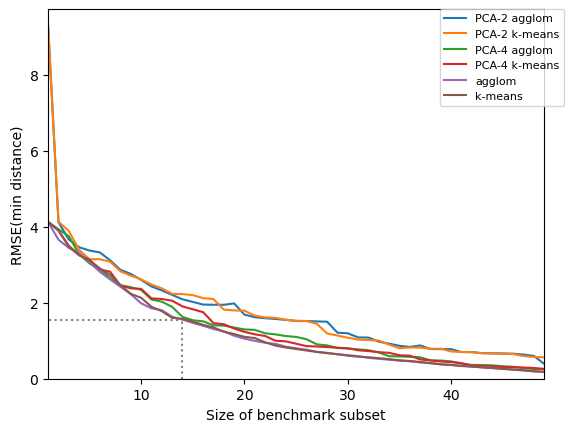

In [203]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
for i, predictor in enumerate(subsetter_df.index.levels[0]):
    ks = subsetter_df.loc[predictor, :].index
    rmse_dist = subsetter_df.loc[predictor, :]["rmse-dist"]
    rmse_accuracy = subsetter_df.loc[predictor, :]["r-accuracy"]
    ax.plot(ks, rmse_dist, color=matplotlib.cm.tab10.colors[i], label=predictor)
xmax = subsetter_df.index.levels[1].max()
ax.set_xlim(1, xmax)
ax.set_ylim(0, None)
opt_y = subsetter_df.loc["agglom", opt_x]["rmse-dist"]
print(f"{opt_y=:.1f}")
ax.plot([opt_x, opt_x], [0, opt_y], color="gray", linestyle=":")
ax.plot([0, opt_x], [opt_y, opt_y], color="gray", linestyle=":")
ax.set_xlabel("Size of benchmark subset")
ax.set_ylabel("RMSE(min distance)")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, prop={"size": 8})
fig.savefig(output_dir / "subsetting-dist.pdf", bbox_inches="tight")

opt_y=0.023, numpy.exp(opt_y)=1.023, numpy.exp(2*opt_y)=1.047
Linear model gets within 2% 65% of the time and 5% 95% of the time


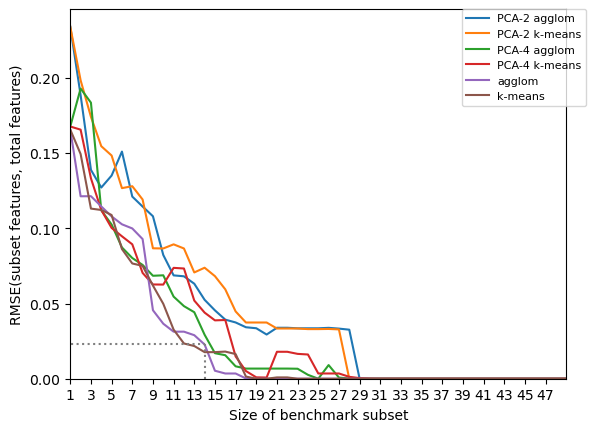

In [204]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
for i, predictor in enumerate(subsetter_df.index.levels[0]):
    ks = subsetter_df.loc[predictor, :].index
    rmse_dist = subsetter_df.loc[predictor, :]["rmse-dist"]
    rmse_accuracy = subsetter_df.loc[predictor, :]["rmse-accuracy"]
    ax.plot(ks, rmse_accuracy, color=matplotlib.cm.tab10.colors[i], label=predictor)
xmax = subsetter_df.index.levels[1].max()
ax.set_xticks(range(1, xmax, 2))
ax.set_xlim(1, xmax)
ax.set_ylim(0, None)
opt_y = subsetter_df.loc["agglom", opt_x]["rmse-accuracy"]
print(f"{opt_y=:.3f}, {numpy.exp(opt_y)=:.3f}, {numpy.exp(2*opt_y)=:.3f}")
ax.plot([opt_x, opt_x], [0, opt_y], color="gray", linestyle=":")
print(f"Linear model gets within {100 * (numpy.exp(opt_y) - 1):.0f}% 65% of the time and {100 * (numpy.exp(opt_y*2) - 1):.0f}% 95% of the time")
ax.plot([0, opt_x], [opt_y, opt_y], color="gray", linestyle=":")
ax.set_xlabel("Size of benchmark subset")
ax.set_ylabel("RMSE(subset features, total features)")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, prop={"size": 8})
fig.savefig(output_dir / "subsetting-accuracy.pdf", bbox_inches="tight")

In [205]:
benchmark_subsetter = DimReducerAndClusterer(
    NoReduction(),
    sklearn.cluster.AgglomerativeClustering(n_clusters=opt_x, linkage="ward", compute_distances=True),
)
selected_benchmarks, _ = benchmark_subsetter.select_benchmarks(benchmarks_by_all_features)

In [206]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return linkage_matrix, scipy.cluster.hierarchy.dendrogram(linkage_matrix, **kwargs)

In [207]:
groups2sizes = dict(agged.loc["(none)"]["workload_kind"].value_counts())

In [208]:
import collections
def members2str(members: list[int]) -> str:
    groups2members = collections.defaultdict(set[int])
    for member in members:
        groups2members[agged.loc["(none)"]["workload_kind"].iloc[member]].add(
            agged.loc["(none)"]["workload_shortname"].iloc[member]
        )
    return ", ".join(
        group + " (" + (
            "all"
            if len(shortnames)== groups2sizes[group]
            else (
                "rest"
                if len(shortnames)== groups2sizes[group] - 1
                else (
                    str(len(shortnames))
                    if len(shortnames) == groups2sizes[group] > 2
                    else ", ".join(shortnames)
                )
            )
        ) + ")"
        for group, shortnames in groups2members.items()
    )

In [209]:
label2members = [[] for _ in range(benchmark_subsetter.n_benchmarks)]
for member, label in enumerate(benchmark_subsetter.cluster_labels):
    label2members[label].append(member)
linreg = sklearn.linear_model.LinearRegression(positive=True)
linreg.fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
for label, (center, members, weight) in sorted(
    enumerate(zip(benchmark_subsetter.selected_benchmarks, label2members, linreg.coef_)),
    key=lambda pair: pair[1][2],
    reverse=True
):
    assert center in members
    members = [member for member in members if member != center]
    center_name = "{" + benchmark_names[center] + "}"
    print(f"{weight*100: 4.1f} & \\textbf{center_name:90s} \\\\".replace(" ()", "").replace("_", "\\_"))
    if members:
        print(f"     & {members2str(members):97s} \\\\".replace(" ()", "").replace("_", "\\_"))
print("\\midrule")
print(f"{linreg.coef_.sum()*100:.1f} & \\textbf{{Sum}} \\\\")

 39.1 & \textbf{IO bench lmbench (catch-signal)}                                                          \\
     & BLAST  (rest), CPU bench SPLASH-3 (ocean, radix, cholesky, volrend, spatial, nsquared, radiosity, lu), Data science Notebook (nb-2), FTP srv/client (all), HTTP srv/traffic (minihttp), IO bench lmbench (install-signal, read, select-file, mmap, write, protection-fault, getppid, bw\_pipe, bw\_unix, page-fault, select-tcp, bw\_file\_rd), Tar Archive (bzip2) \\
 19.9 & \textbf{Data science python (python-import)}                                                      \\
     & BLAST  (blastn), CPU bench SPLASH-3 (raytrace), Compile w/latex (all), Data science Notebook (rest), Data science python (rest), IO bench lmbench (fstat, stat), Tar Archive (gzip), Tar Unarchive (rest), VCS checkout  (rest) \\
 8.2 & \textbf{Tar Unarchive (pbzip2)}                                                                   \\
     & HTTP srv/traffic (lighttpd), Tar Archive (pigz, pbzip2)            

In [210]:
linkage, R = plot_dendrogram(
    benchmark_subsetter.clusterer,
    ax=ax,
    truncate_mode="lastp",
    p=20,
    no_plot=True,
)

In [211]:
def get_members(id: int) -> str:
    if 0 <= id < n_benchmarks:
        #assert id in benchmark_subsetter.selected_benchmarks
        return [id]
    elif n_benchmarks <= id < n_benchmarks * 2:
        left_child = int(linkage[id - n_benchmarks][0])
        right_child = int(linkage[id - n_benchmarks][1])
        return get_members(left_child) + get_members(right_child)
    else:
        raise ValueError()

In [212]:
def leaf_label_func_members(id: int, limit: int = 35) -> str:
    s = members2str(get_members(id))
    if len(s) > limit:
        return s[:limit] + "..."
    else:
        return s

In [213]:
def link_color_func(id: int) -> str:
    if 0 <= id < n_benchmarks:
        #assert id in benchmark_subsetter.selected_benchmarks
        color = colors[benchmark_subsetter.cluster_labels[id]]
        return "#" + "".join(map(lambda val: f"{int(val * 255):02x}", color))
    elif n_benchmarks <= id < n_benchmarks * 2:
        left_child = int(linkage[id - n_benchmarks][0])
        right_child = int(linkage[id - n_benchmarks][1])
        left_color = link_color_func(left_child)
        right_color = link_color_func(right_child)
        if left_color == right_color:
            return left_color
        else:
            return "gray"
    else:
        raise ValueError()

In [214]:
def leaf_label_func_representative(id: int, is_center=True) -> str:
    if 0 <= id < n_benchmarks:
        if is_center:
            #assert id in benchmark_subsetter.selected_benchmarks
            return benchmark_names[benchmark_subsetter.selected_benchmarks[benchmark_subsetter.cluster_labels[id]]]
        else:
            return 
    elif n_benchmarks <= id < n_benchmarks * 2:
        left_child = int(linkage[id - n_benchmarks][0])
        right_child = int(linkage[id - n_benchmarks][1])
        left_child_rep = leaf_label_func_representative(left_child)
        right_child_rep = leaf_label_func_representative(right_child)
        if left_child_rep == right_child_rep:
            return left_child_rep
        else:
            return None
        #    #return left_child_rep + " | " + right_child_rep
    else:
        raise ValueError()

<a list of 0 Line2D objects>

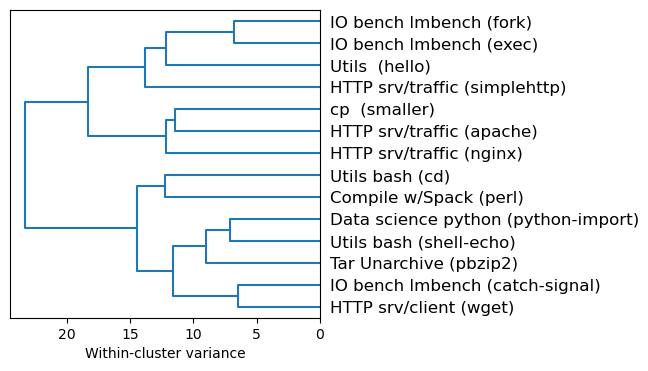

In [215]:
fig = matplotlib.pyplot.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
linkage, R = plot_dendrogram(
    benchmark_subsetter.clusterer,
    ax=ax,
    leaf_label_func=leaf_label_func_representative,
    truncate_mode="lastp",
    p=opt_x,
    color_threshold=0,#color_threshold,
    labels=benchmark_names,
    orientation="left",
    #link_color_func=link_color_func,
)
ax.set_xlabel("Within-cluster variance")
fig.savefig(output_dir / "dendrogram.pdf", bbox_inches="tight")
fig.savefig(output_dir / "dendrogram.svg", bbox_inches="tight")
ax.get_lines()

<a list of 0 Line2D objects>

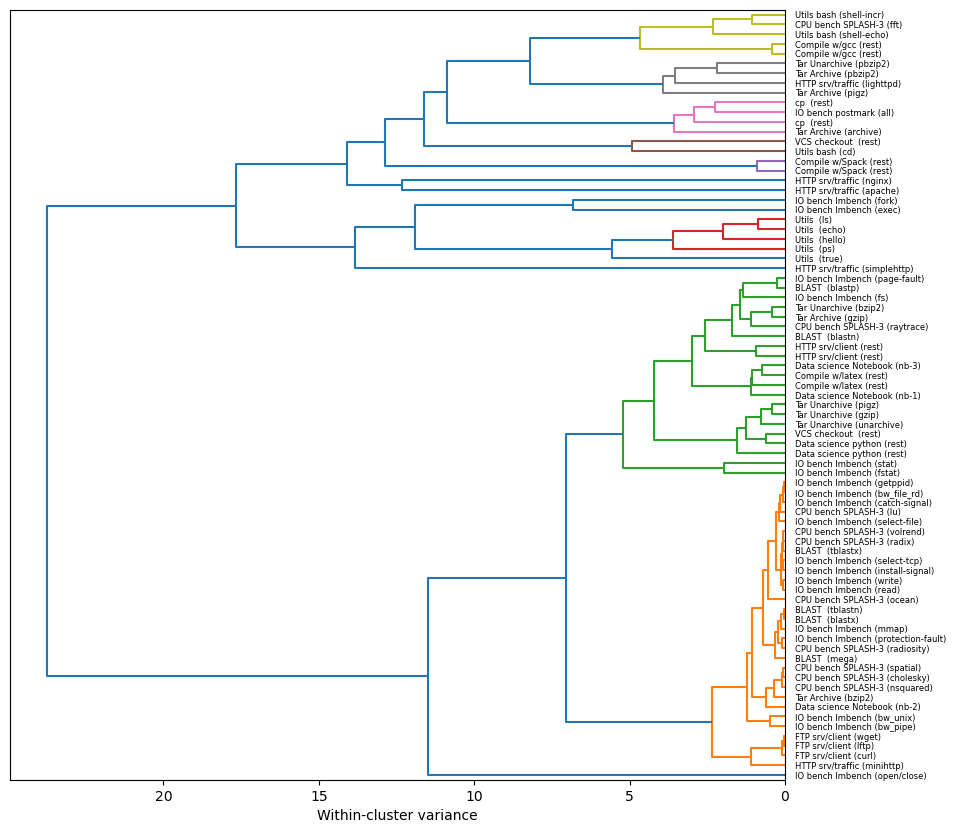

In [92]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
linkage, R = plot_dendrogram(
    benchmark_subsetter.clusterer,
    ax=ax,
    leaf_label_func=leaf_label_func_members,
    # truncate_mode="lastp",
    # p=opt_x,
    color_threshold=linkage[-opt_x, 2],
    labels=benchmark_names,
    orientation="left",
    #link_color_func=link_color_func,
)
ax.set_xlabel("Within-cluster variance")
fig.savefig(output_dir / "dendrogram_full.pdf", bbox_inches="tight")
ax.get_lines()

In [93]:
import matplotlib.cm
colors = matplotlib.cm.tab20.colors

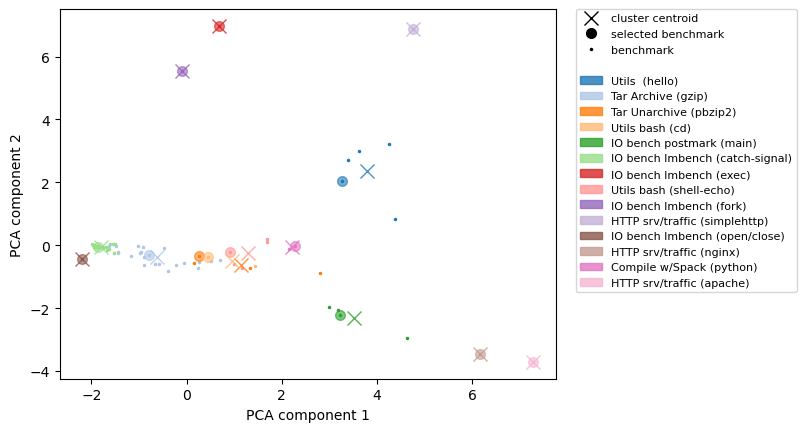

In [94]:
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
pca = sklearn.decomposition.PCA(n_components=2).fit(benchmarks_by_all_features)
for i in range(len(benchmarks_by_all_features)):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=colors[benchmark_subsetter.clusterer.labels_[i]],
        marker=".",
        markersize=3,
    )
for cluster_label, i in enumerate(selected_benchmarks):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=(*colors[cluster_label][:3], 0.6),
        marker="o",
        markersize=7,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(benchmark_subsetter.cluster_centers):
    ax.plot(
        pca.transform(cluster_center[numpy.newaxis, :])[0, 0],
        pca.transform(cluster_center[numpy.newaxis, :])[0, 1],
        color=(*colors[cluster_label][:3], 0.8),
        marker="x",
        markersize=10,
        markeredgewidth=1,
    )
ax.legend(
    handles=[
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="x", markersize=10, markeredgewidth=1, label="cluster centroid"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="o", markersize=7, markeredgewidth=1, label="selected benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=3, label="benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="", label=""),
        *[
            matplotlib.patches.Patch(color=(*colors[cluster_label], 0.8), label=benchmark_names[i])
            for cluster_label, i in enumerate(selected_benchmarks)
        ],
    ],
    prop={"size": 8},
    bbox_to_anchor=(1.04, 1.0),
    borderaxespad=0,
)
fig.savefig(output_dir / "pca0.pdf", bbox_inches="tight")
xlims = ax.get_xlim()
ylims = ax.get_ylim()

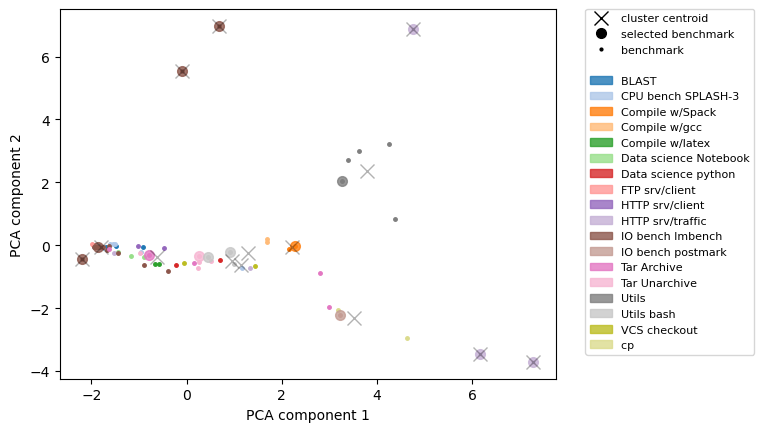

In [95]:
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
for i in range(len(benchmarks_by_all_features)):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=colors[workload_kinds.cat.codes[benchmark_names[i]]],
        marker=".",
        markersize=5,
    )
for i in selected_benchmarks:
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=(*colors[workload_kinds.cat.codes[benchmark_names[i]]], 0.8),
        marker="o",
        markersize=7,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(benchmark_subsetter.cluster_centers):
    ax.plot(
        pca.transform(cluster_center[numpy.newaxis, :])[0, 0],
        pca.transform(cluster_center[numpy.newaxis, :])[0, 1],
        color=(0, 0, 0, 0.3),
        marker="x",
        markersize=10,
        markeredgewidth=1,
    )
import scipy.spatial
#vor = scipy.spatial.Voronoi(predictor.kmeans.cluster_centers_[:, :2])
#scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.legend(
    handles=[
        matplotlib.lines.Line2D([0], [0], linestyle="", marker="x", markersize=10, color="black", label="cluster centroid"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="o", markersize=7, markeredgewidth=1, label="selected benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=4, label="benchmark"),
        matplotlib.lines.Line2D([0], [0], linestyle="", marker="", label=""),
        *[
            matplotlib.patches.Patch(color=(*color, 0.8), label=workload_kind)
            #matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", markersize=7, color=color, label=workload_kind)
            for color, workload_kind in zip(colors, workload_kinds.cat.categories)
        ],
    ],
    bbox_to_anchor=(1.4, 1.0),
    borderaxespad=0,
    prop={"size": 8},
)
fig.savefig(output_dir / "pca1.pdf", bbox_inches="tight")

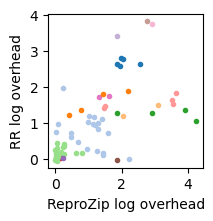

In [157]:
fig = matplotlib.figure.Figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
collector0 = "ReproZip"
collector1 = "RR"
for i in range(len(benchmarks_by_all_features)):
    ax.plot(
        agged.loc[collector0, "log_rel_slowdown"].iloc[i],
        agged.loc[collector1, "log_rel_slowdown"].iloc[i],
        color=colors[benchmark_subsetter.clusterer.labels_[i]],
        marker="o",
        markersize=3,
    )
# ax.legend(
#     handles=[
#         *[
#             matplotlib.lines.Line2D([0], [0], marker="o", markersize=3, linestyle="", color=(*colors[cluster_label], 0.8), label=benchmark_names[i])
#             for cluster_label, i in enumerate(selected_benchmarks)
#         ],
#     ],
#     bbox_to_anchor=(1.1, 1.0),
#     borderaxespad=0,
#     prop={"size": 8},
# )
ax.set_xlabel(f"{collector0} log overhead")
ax.set_ylabel(f"{collector1} log overhead")
display(fig)
fig.savefig(output_dir / "clustering2.svg", bbox_inches="tight")

# Let's play the new system game

In [335]:
import sklearn.pipeline
model = sklearn.pipeline.Pipeline([
    ("scalar", sklearn.preprocessing.StandardScaler(with_mean=False, with_std=True)),
    ("lasso", sklearn.linear_model.LassoCV(fit_intercept=True, positive=True)),
])

important_features = collections.Counter[int]()
for i in range(1, n_systems):
    model.fit(abs_benchmarks_by_features, abs_systems_by_benchmarks[i])
    for i, weight in enumerate(model.named_steps["lasso"].coef_):
        if numpy.fabs(weight) > 1e-11:
            important_features[i] += 1
important_features = [
    val for val, counter in important_features.most_common()
]
print(r"\begin{tabular}{lll" + "l" * (len(important_features) - 1) + "}")
print(r"\toprule")
print(" & ".join([
    "{:10s}".format("Collector"),
    "{:18s}".format(r"95\% interval (\%)"),
    "{:8s}".format("Intercept"),
    "{:18s}".format("Time multiplier"),
    "\multicolumn{" + str(len(important_features) - 1) + "}{c}{Feature weights}",
]) + r" \\")
print(" & ".join([
    "{:10s}".format(""), # collector
    "{:18s}".format(""), # rmse
    "{:9s}".format(""), # intercept
    "{:18s}".format(""), # time multiplier
    *("{:18s}".format(
        abs_feature_names[i].replace("_", " "))
        for i in important_features
        if i != abs_feature_names.index("noprov_time")
     ),
]) + r" \\")
print(r"\midrule")
for i in range(1, n_systems):
    model.fit(abs_benchmarks_by_features, abs_systems_by_benchmarks[i])
    rmse = numpy.mean(sklearn.model_selection.cross_validate(
        model,
        abs_benchmarks_by_features,
        abs_systems_by_benchmarks[i],
        scoring=lambda model, X, y: numpy.mean(numpy.log(numpy.fabs(model.predict(X) - y) / y)),
        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0),
    )["test_score"])
    coefs = model.named_steps['lasso'].coef_ / model.named_steps["scalar"].scale_
    print(" & ".join([
        f"{collector_names[i]:10s}",
        f"{(100 * (numpy.exp(2 * rmse))): 18.1f}",
        f"{model.named_steps['lasso'].intercept_: 9.1f}",
        f"{coefs[abs_feature_names.index('noprov_time')]: 18.1f}",
        *(
            f"{coefs[i]*1e6: 18.0f}" if coefs[i] > 1e-7
            else f"{'':18s}"
            for i in important_features
            if i != abs_feature_names.index("noprov_time")
        ),
    ]) + r" \\")
print(r"\bottomrule")
print(r"\end{tabular}")

\begin{tabular}{llllllllll}
\toprule
Collector  & 95\% interval (\%) & Intercept & Time multiplier    & \multicolumn{7}{c}{Feature weights} \\
           &                    &           &                    & metadata syscalls  & file syscalls      & IPC syscalls       & dir syscalls       & chdir syscalls     & other syscalls     & socket syscalls    \\
\midrule
CARE       &                1.5 &       0.7 &                1.0 &                  3 &                  8 &                444 &                  2 &               1326 &                810 &                    \\
RR         &               42.6 &       5.2 &                1.1 &                 12 &                 17 &               4725 &                 17 &              10344 &               1031 &               1163 \\
ReproZip   &               27.4 &       8.8 &                1.0 &                 16 &                 16 &               4287 &                    &                    &                203 &           

In [221]:
import sklearn.pipeline
model = sklearn.pipeline.Pipeline([
    ("scalar", sklearn.preprocessing.StandardScaler(with_mean=False, with_std=True)),
    ("lasso", sklearn.linear_model.LassoCV(fit_intercept=True, positive=True)),
])

important_features = collections.Counter[int]()
for i in range(1, n_systems):
    model.fit(abs_benchmarks_by_features, abs_systems_by_benchmarks[i])
    for i, weight in enumerate(model.named_steps["lasso"].coef_):
        if numpy.fabs(weight) > 1e-11:
            important_features[i] += 1
important_features = [
    val for val, counter in important_features.most_common()
]
print(",".join([
    "{:10s}".format("Collector"),
    "{:18s}".format(r"95% interval (%)"),
    "{:8s}".format("Intercept"),
    "{:18s}".format("Time multiplier"),
    *("{:18s}".format(
        abs_feature_names[i].replace("_", " "))
        for i in important_features
        if i != abs_feature_names.index("noprov_time")
     ),
]))
for i in range(1, n_systems):
    model.fit(abs_benchmarks_by_features, abs_systems_by_benchmarks[i])
    rmse = numpy.mean(sklearn.model_selection.cross_validate(
        model,
        abs_benchmarks_by_features,
        abs_systems_by_benchmarks[i],
        scoring=lambda model, X, y: numpy.mean(numpy.log(numpy.fabs(model.predict(X) - y) / y)),
        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0),
    )["test_score"])
    coefs = model.named_steps['lasso'].coef_ / model.named_steps["scalar"].scale_
    print(",".join([
        f"{collector_names[i]:10s}",
        f"{(100 * (numpy.exp(2 * rmse))): 18.1f}",
        f"{model.named_steps['lasso'].intercept_: 9.1f}",
        f"{coefs[abs_feature_names.index('noprov_time')]: 18.1f}",
        *(
            f"{coefs[i]*1e6: 18.0f}" if coefs[i] > 1e-7
            else f"{'':18s}"
            for i in important_features
            if i != abs_feature_names.index("noprov_time")
        ),
    ]))

Collector ,95% interval (%)  ,Intercept,Time multiplier   ,file syscalls     ,metadata syscalls ,dir syscalls      ,IPC syscalls      ,socket syscalls   ,chdir syscalls    ,other syscalls    
CARE      ,               1.3,      0.6,               1.0,                 8,                 3,                 3,               670,                  ,              2426,                  


/nix/store/9kgcvj0qdcf01mq20d6ickh63az0bjn2-python3-3.10.13-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.41104660794372, tolerance: 86.94613730745516
  model = cd_fast.enet_coordinate_descent_gram(
/nix/store/9kgcvj0qdcf01mq20d6ickh63az0bjn2-python3-3.10.13-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.32306228773814, tolerance: 86.94613730745516
  model = cd_fast.enet_coordinate_descent_gram(


RR        ,              41.9,      6.5,               1.1,                37,                  ,                 8,                  ,              1144,                  ,             13568
ReproZip  ,              17.0,      5.8,               1.0,                49,                17,                11,              2187,               128,                  ,                  
fsatrace  ,               0.1,      0.0,               1.0,                  ,                  ,                  ,                  ,                  ,                  ,                  
strace    ,               7.0,      1.7,               1.0,                11,                 7,                  ,               678,               143,              1287,                  


In [214]:
import scipy.linalg.interpolative

class Regression(NewBenchmarkPredictor):
    """
    This method simply regresses performance on the set of passed features.

    None means all.

    No linear method should be able to do better in RMSE, but dimensionality reduction may help with AIC.

    Note that the cross-validation score will be overestimated,
    because "variable selection" is not being re-evaluated strictly on the training set.
    """
    def __init__(self, features: list[int] | None) -> None:
        self.pre_features = features

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        self.features = self.pre_features if self.pre_features is not None else list(range(benchmarks_by_features.shape[1]))
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks,
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def get_important_features(self) -> list[int]:
        return self.features

    def __str__(self) -> str:
        return f"linear regression"

NameError: name 'NewBenchmarkPredictor' is not defined

In [ ]:
import scipy.linalg.interpolative

class LowRankMatrixFactorization(NewBenchmarkPredictor):
    """
    Like Regression, but use a low-rank compression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.a.flatten()) + len(self.b.flatten()) + 1

    def get_important_features(self) -> list[int]:
        coeffs = self.a @ self.b
        feature_importance = numpy.fabs(coeffs.sum(axis=0))
        normed_feature_importance = feature_importance / feature_importance.sum()
        return [
            feature
            for feature, importance in enumerate(normed_feature_importance)
            if importance > 0.2
        ]

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        tmp = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features.T)
        u, s, vh = numpy.linalg.svd(tmp, full_matrices=False)
        self.a = (u[:, :self.dim] * s[:self.dim])
        self.b = vh[:self.dim, :]
        log_likelihood = naive_log_likelihood(
            self.a @ self.b @ benchmarks_by_features.T,
            systems_by_benchmarks,
        )
        return self.a @ self.b @ new_benchmarks_by_features.T, log_likelihood

    def __str__(self) -> str:
        return f"low-rank factorization"

In [ ]:
import scipy.linalg.interpolative

class GreedySubsetMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries to select only dim features.

    This is subtly different from "compressing to a matrix of rank dim".

    Using only dim features, means the other coefficients **have to be** zero.

    It's greedy because it picks the best feature, and adds next best given the current set, etc.
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        selected_features = []
        while len(selected_features) < self.dim:
            unselected_features = [
                feature
                for feature in range(benchmarks_by_features.shape[1])
                if feature not in selected_features
            ]
            selected_features = min([
                selected_features + [candidate_feature]
                for candidate_feature in unselected_features
            ], key=test_goodness)
        self.features = selected_features
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"greedy feature selection"

In [ ]:
import random

class BestOfNMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries `iters` feature subsets, selecting the best.
    """
    def __init__(self, dim: int, iters: int) -> None:
        self.dim = dim
        self.iters = iters

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        rng = random.Random(0)
        best_feature_set = None
        best_feature_score = None
        features = list(range(benchmarks_by_features.shape[1]))
        for _ in range(self.iters):
            feature_set = rng.sample(features, self.dim)
            score = test_goodness(feature_set)
            if best_feature_score is None or score < best_feature_score:
                best_feature_score = score
                best_feature_set = feature_set
        self.features = best_feature_set
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"random-best"

In [ ]:
def test_benchmark_predictors(
    predictors: list[NewBenchmarkPredictor],
) -> None:
    benchmarks = list(range(n_benchmarks))
    test_size = 0.1
    cv_splitter = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=test_size, random_state=0)
    predictor_records = []
    for predictor in predictors:
        predictor_rmse = list[int]()
        important_features = collections.Counter()
        for train_benchmarks, test_benchmarks in cv_splitter.split(benchmarks):
            predicted, _ = predictor.predict_new_benchmark(
                systems_by_benchmarks[:, train_benchmarks],
                benchmarks_by_features[train_benchmarks, :],
                benchmarks_by_features[test_benchmarks, :],
            )
            for important_feature in predictor.get_important_features():
                important_features[important_feature] += 1
            actual = systems_by_benchmarks[:, test_benchmarks]
            predictor_rmse.append(root_mean_squared_error(actual, predicted))
        _, log_likelihood = predictor.predict_new_benchmark(systems_by_benchmarks, benchmarks_by_features, benchmarks_by_features)
        n_datapoints = len(systems_by_benchmarks.flatten()) + len(benchmarks_by_features.flatten())
        params = predictor.n_parameters()
        predictor_aicc = aicc(params, log_likelihood, n_datapoints)
        important_feature_names = {feature_names[feature]: count for feature, count in important_features.most_common()}
        predictor_records.append({
            "predictor": str(predictor),
            "rmse": numpy.mean(predictor_rmse),
            "rmse stddev": numpy.std(predictor_rmse),
            "log_likelihood": log_likelihood,
            "params": params - 1,
            "aicc": predictor_aicc,
            "features selected": important_feature_names,
        })
        print(
            f"{numpy.mean(predictor_rmse): 5.2f}",
            f"{numpy.std(predictor_rmse): 5.2f}",
            f"{log_likelihood: 7.1f}",
            f"{params: 4d}",
            f"{predictor_aicc: 9.2f}",
            predictor,
            important_feature_names,
        )
    return pandas.DataFrame.from_records(predictor_records)

benchmark_predictors = test_benchmark_predictors([
    Regression(None),
    #Regression([feature_names.index("cputime_per_sec")]),
    #Regression([feature_names.index("chmod_syscalls_per_sec")]),
    *[
        LowRankMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        GreedySubsetMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        BestOfNMatrixFactorization(i, 1000)
        for i in range(1, n_features + 1)
    ]
])

In [ ]:
benchmark_predictors.sort_values("rmse")

In [ ]:
tmpdf = benchmark_predictors.sort_values(["predictor", "params"]).set_index("predictor")
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
clip_ymax = 2
for i, predictor in enumerate(tmpdf.index.unique()):
    if " feat " in str(predictor):
        continue
    xs = tmpdf.loc[predictor]["params"]
    mid = tmpdf.loc[predictor]["rmse"]
    err = tmpdf.loc[predictor]["rmse stddev"]
    low = numpy.clip(mid - err / 5, 0, clip_ymax)
    high = numpy.clip(mid + err / 5, 0, clip_ymax)
    #ax.fill_between(xs, low, high, alpha=0.2, color=colors[i])
    ax.plot(
        xs,
        mid,
        color=matplotlib.cm.tab10.colors[i],
        label=predictor,
        #alpha=0.5,
        marker="o" if predictor == "linear regression" else "",
        linestyle="" if predictor == "linear regression" else "-",
    )
#ax.set_ylim(0, clip_ymax)
xmax = df["params (⇩ = better)"].max()
#ax.set_xticks(range(0, xmax, 2))
ax.set_xlim(1, xmax)
ax.set_xlabel("Parameters")
ax.set_ylabel("Cross-validated RMSE(log(overhead ratio))")
#ax.set_title("Competition for best subsetting algorithm")
ax.legend(
    #bbox_to_anchor=(1.04, 1), borderaxespad=0
)
fig.savefig(output_dir / "predictive-performance.pdf", bbox_inches="tight")

In [ ]:
pred = GreedySubsetMatrixFactorization(4)
_, _ = pred.predict_new_benchmark(systems_by_benchmarks, benchmarks_by_features, benchmarks_by_features)
print(
    pandas.DataFrame(
        index=[collector_names[i] for i in range(n_systems)],
        columns=[feature_names[i] for i in pred.get_important_features()],
        data=pred.systems_by_features,
    )
    .map("{:.6f}".format)
    .to_latex()
    .replace("_", " ")
)

In [ ]:
pred.systems_by_features

In [ ]:
n_features

In [ ]:
n_benchmarks